# Exercises

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
import pickle
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

from tqdm import tqdm

### Exercise 1
---
Use the sklearn `make_blobs()` function, in the same way that we used in the lesson, to generate a *non linearly separable* dataset with 2 features.  
Fit a linear SVM to the dataset many times, varying the slack hyperparameter $C$, and calculate the model performance in classifying the data.  
What is, approximately, a the best value of the $C$ hyperparameter for this dataset?

In [20]:
n = 100
ratio = .8
aux = int(n*ratio)
X,Y = make_blobs(n_samples=200,n_features =2,centers=[[-1,0],[1,0]],cluster_std=.8)
X_train = X[:aux]
X_test = X[aux:]
Y_train = Y[:aux]
Y_test = Y[aux:]

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1901.28it/s]


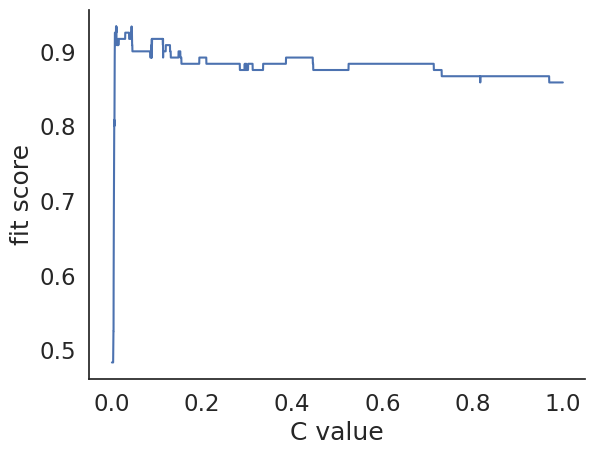

Highest score:0.933, C value:0.0091


In [25]:
C = np.linspace(0.0001, 1, 10000)
scores = []

for c in tqdm(C):
    svc_model = svm.SVC(kernel='linear',C=c);
    svc_model.fit(X_train, Y_train)
    score_ = svc_model.score(X_test,Y_test)
    #print(f'C={c}, score={score_:.3}')
    scores.append(score_)

plt.plot(C, scores)
plt.xlabel('C value')
plt.ylabel('fit score')
plt.show()
print(f'Highest score:{np.max(scores):.3}, C value:{C[np.argmax(scores)]}')

While the exact distribution of the scores depend on the randomly produced set of data, there is a trend showing that the best scores are usally found at a c value close to zero.

### Exercise 2
---
Repeat exercise 1, but using a non-linear SVM model (the sklearn class `SVC` uses [Radial Basis Functions](https://en.wikipedia.org/wiki/Radial_basis_function) as a default, check its documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)). 
To have a fairer assessment of the performance, train the model on a fraction (e.g. 80%) of the data, and test it on the other 20%.
Compare the performance of a linear SVC and a RBF SVC for dataset that are increaslingly non-linearly-separable.


In [2]:
def generateData(ratio ,n_samples, cluster_std):
    X,Y = make_blobs(n_samples=200,n_features =2,centers=[[-1,0],[1,0]],cluster_std=.8)
    return X[:ratio], X[ratio:], Y[:ratio], Y[ratio:] #Xtrain, Xtest, Ytrain, Ytest

def GetRbfScores(C):
    scores = []
    for c in tqdm(C):
        svc_model = svm.SVC(kernel='rbf',C=c);
        svc_model.fit(X_train, Y_train)
        score_ = svc_model.score(X_test,Y_test)
        #print(f'C={c}, score={score_:.3}')
        scores.append(score_)
    return scores

def GetLinScores(C):
    scores = []
    for c in tqdm(C):
        svc_model = svm.SVC(kernel='linear',C=c);
        svc_model.fit(X_train, Y_train)
        score_ = svc_model.score(X_test,Y_test)
        #print(f'C={c}, score={score_:.3}')
        scores.append(score_)
    return scores

In [16]:
n = 100
ratio = int(n*.8)
C = np.linspace(0.0001, 0.5, 100)
std = np.linspace(0.8, 7.5)
best_scores_lin = []
best_scores_rbf = []

for std_ in tqdm(std):
    X_train, X_test, Y_train, Y_test = generateData(ratio, n, std_)
    scores_lin = []
    scores_rbf = []
    for c in (C):
        # - lin -
        svc_model = svm.SVC(kernel='linear',C=c);
        svc_model.fit(X_train, Y_train)
        scores_lin.append(svc_model.score(X_test,Y_test))
        # - rbf -
        svc_model_rbf = svm.SVC(kernel='rbf',C=c);
        svc_model_rbf.fit(X_train, Y_train)
        scores_rbf.append(svc_model_rbf.score(X_test,Y_test))
    best_scores_lin.append(np.max(scores_lin))
    best_scores_rbf.append(np.max(scores_rbf))

100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  8.06it/s]


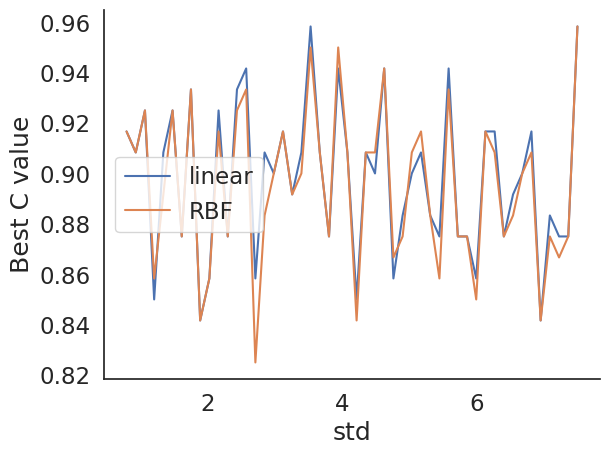

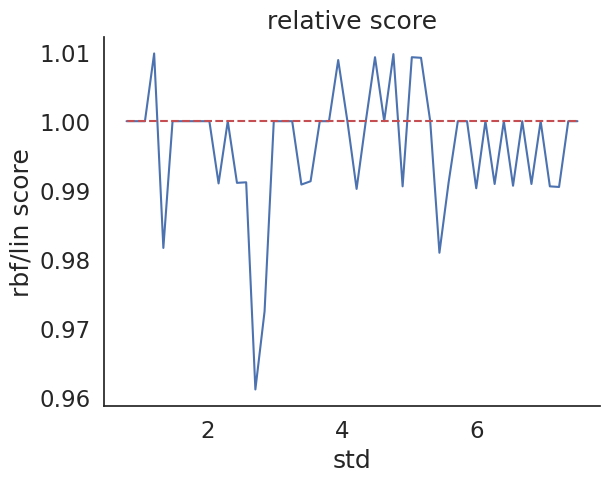

In [23]:
plt.plot(std, best_scores_lin, label='linear')
plt.plot(std, best_scores_rbf, label='RBF')
plt.legend()
plt.xlabel('std')
plt.ylabel('Best C value')
plt.show()
plt.plot(std, np.divide(best_scores_rbf, best_scores_lin))
plt.hlines(1, std[0], std[-1], colors='r', linestyles='dashed')
plt.title('relative score')
plt.xlabel('std')
plt.ylabel('rbf/lin score')
plt.show()

Based on the best c value for each std, it is imminent from the plots, that neither linear or rbf is significantly better for the dataset. 

### Exercise 3
---
Use the code below to simulate new data.
Generate data and then decode the stimulus identity, see how the decoding performance change when you change the following:

- The amplitude of the noise in the firing rate
- The amplitude of the stimulus modulation of the firing rate
- The number of neurons

Plot and comment.

## Useful code
---


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.preprocessing import StandardScaler

n_stim_type = 2; # number of different stimuli
average_firing_rate = 5; # average firing rate across the population
s_rate = 10000 # the sampling rate of our emulated recording system
noise_rate = 1 # we are going to add some spike noise non related to the task
n_stim = 100 # number of stimuli
stim_dur = 2 #stimulus duration (in seconds)
is_interval = 3 # interval between stimuli  (in seconds)
onset = 1 # in seconds before stimulus onset
offset = 1 # in second after stimulus offset
binwidth = 0.1 # in seconds (100 ms)
bins = np.arange(-onset,stim_dur+offset+binwidth,binwidth)
bin_centers = [(bins[i+1]+bins[i])/2 for i in range(len(bins)-1)]
n_splits = 5

In [37]:
def ex3(cells, sig_stim, sig_ns):
    n_cells = cells; # number of cells to simulate
    sigma_stim = sig_stim # amplitude of stimulus related modulation
    sigma_noise = sig_ns #amplitude of noise
    
    # generate baseline rates from exponential distirbution
    cell_rate_baseline = np.random.exponential(average_firing_rate,size=n_cells)
    # create stimulus average responses, perturbing the population firng rate profile
    # we use a multiplicative modulation in opposite directions for the two stimuli
    modulation = sigma_stim*np.random.normal(0,1,size=n_cells)
    noise = sigma_noise*np.random.normal(0,1,size=n_cells)
    cell_rate_stim = {1: cell_rate_baseline * (1+modulation)+noise,2:cell_rate_baseline * (1-modulation)+noise}
    # sets negative firng rate to 0
    cell_rate_stim[1][cell_rate_stim[1]<0]=0
    cell_rate_stim[2][cell_rate_stim[2]<0]=0
    # simulate spiking activity
    stim_onsets = np.arange(0,n_stim*(stim_dur+is_interval),(stim_dur+is_interval)) # onset time of each stimulus (in seconds)
    stim_type = np.asarray([1 for i in range(int(n_stim/2))]+[2 for i in range(int(n_stim/2))]) # identity of each stimulus
    np.random.shuffle(stim_type)
    time = np.arange(0,(n_stim+1)*(stim_dur+is_interval),1.0/s_rate) # vector of the sampled times.
    spike_times = []
    for cell in range(n_cells):
        spikes = np.random.poisson(cell_rate_baseline[cell]/s_rate,size=time.shape)
        for i,stimulus in enumerate(stim_type):
            stim_idxs = np.arange(stim_onsets[i]*s_rate,(stim_onsets[i]+stim_dur)*s_rate)
            spikes[stim_idxs] = np.random.poisson(cell_rate_stim[stimulus][cell]/s_rate,size=stim_idxs.shape)
        spike_times.append(time[spikes>0])
    n_cells = len(spike_times)
    n_trials= len(stim_type)
    X = np.zeros((n_cells,n_trials,len(bins)-1));
    for cell in range(n_cells):    
        for trial in range(n_trials):
            # selects spikes that are in trial
            sp_idx = np.logical_and(spike_times[cell]>stim_onsets[trial]-onset,
                     spike_times[cell]<stim_onsets[trial]+stim_dur+offset)        
            # centers spike times around stimulus onset
            sp_cntr = spike_times[cell][sp_idx]-stim_onsets[trial]
            #bins spikes
            spike_count,_ = np.histogram(sp_cntr,bins)
            #spike_count = zscore(spike_count)
            X[cell,trial,:] = spike_count
    avg_performance = []
    std_performance = []
    for time_bin in range(X.shape[-1]):
            # setting 2-fold cross validation
            kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
            fold_performance = []
            for train_index, test_index in kf.split(X[:,:,time_bin].T,stim_type):
                    X_train, X_test = X[:,train_index,time_bin].T, X[:,test_index,time_bin].T
                    y_train, y_test = stim_type[train_index], stim_type[test_index]
                    clf = svm.LinearSVC(max_iter=1000)
                    clf.fit(X_train, y_train)
                    fold_performance.append(clf.score(X_test,y_test))
            avg_performance.append(np.mean(fold_performance))
            std_performance.append(np.std(fold_performance))
    avg_performance = np.asarray(avg_performance)
    std_performance = np.asarray(std_performance)

    return avg_performance, std_performance

def ex3_plot(avg_performance, std_performance):
    plt.plot(bin_centers,avg_performance)
    plt.fill_between(bin_centers,avg_performance-std_performance,
                     avg_performance+std_performance,alpha=0.2)
    plt.axhline(y=0.5,linestyle='--',label='chance level')
    plt.axvline(x=0,c='r')
    plt.axvline(x=2,c='r')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Decoding performance')
    plt.show()

Plot with 5 cells, 0.1 stimulus sigma, and 0.2 noise sigma.


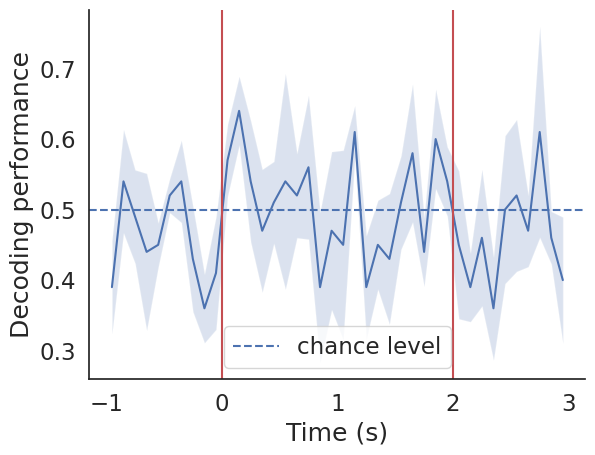

Plot with 5 cells, 0.1 stimulus sigma, and 0.6 noise sigma.


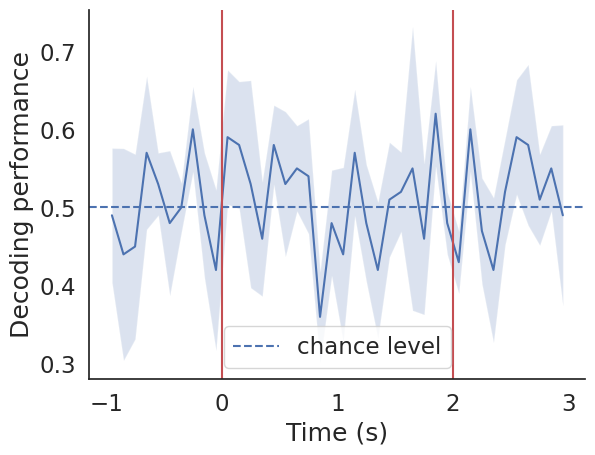

Plot with 5 cells, 0.1 stimulus sigma, and 1.2 noise sigma.


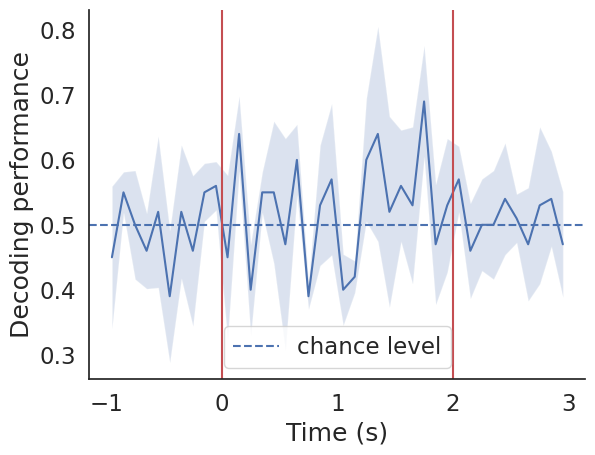

Plot with 5 cells, 0.6 stimulus sigma, and 0.2 noise sigma.


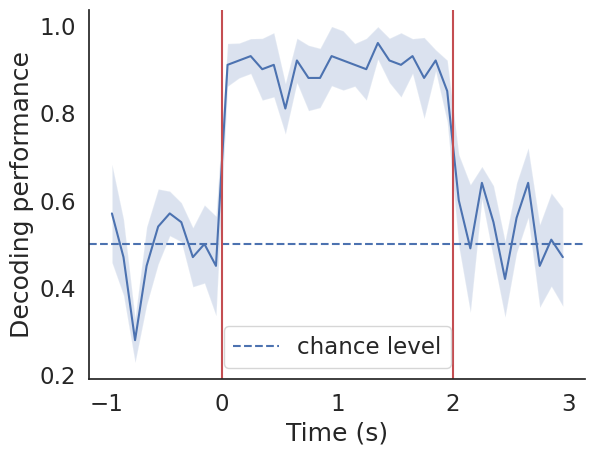

Plot with 5 cells, 0.6 stimulus sigma, and 0.6 noise sigma.


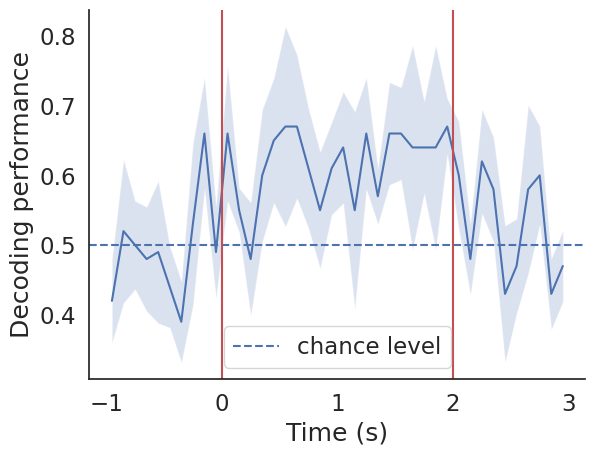

Plot with 5 cells, 0.6 stimulus sigma, and 1.2 noise sigma.


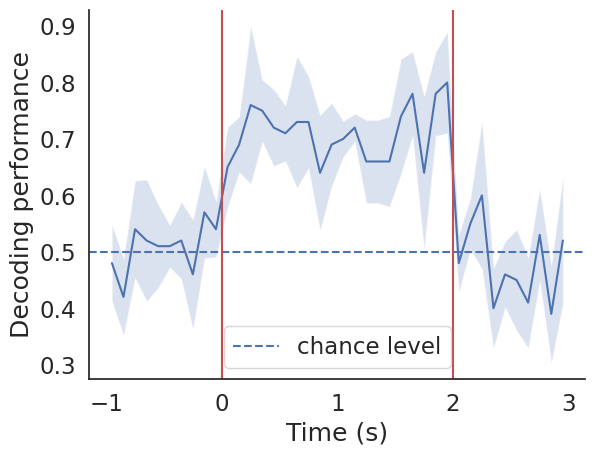

Plot with 5 cells, 1.0 stimulus sigma, and 0.2 noise sigma.


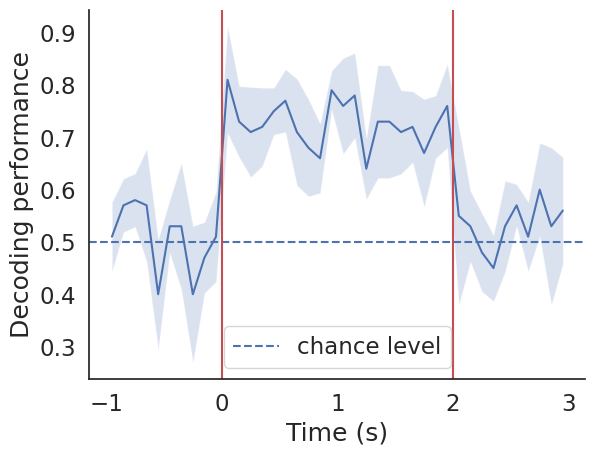

Plot with 5 cells, 1.0 stimulus sigma, and 0.6 noise sigma.


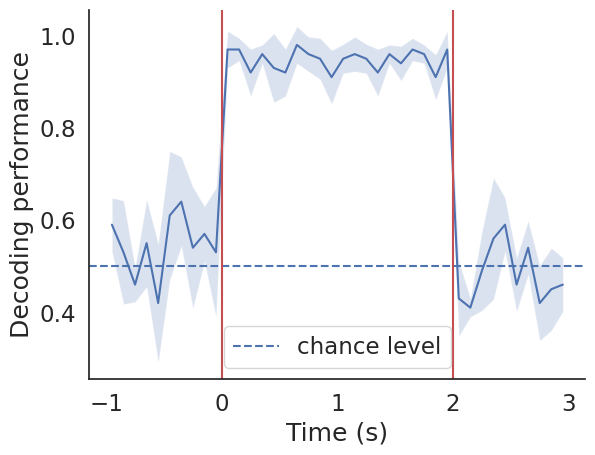

Plot with 5 cells, 1.0 stimulus sigma, and 1.2 noise sigma.


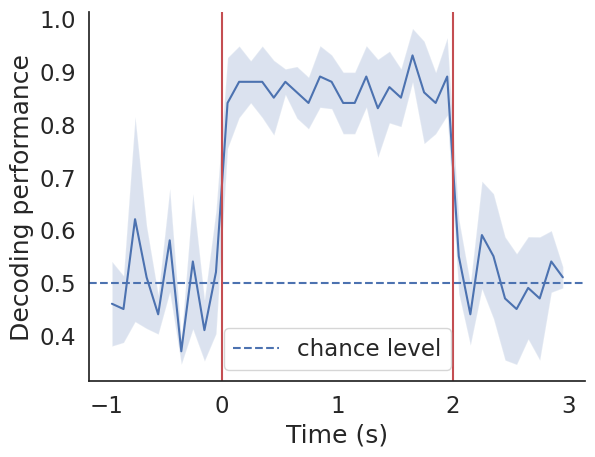

Plot with 20 cells, 0.1 stimulus sigma, and 0.2 noise sigma.


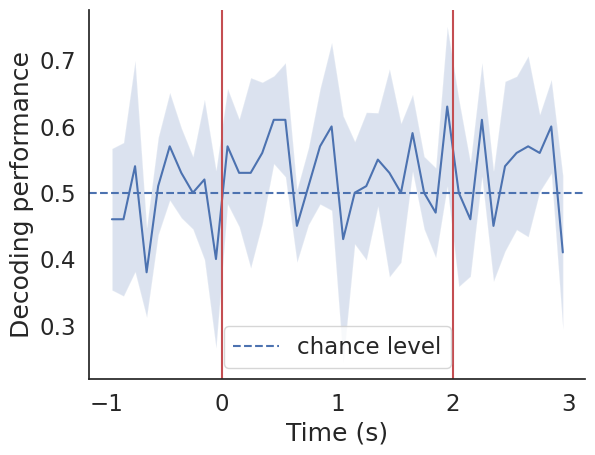

Plot with 20 cells, 0.1 stimulus sigma, and 0.6 noise sigma.


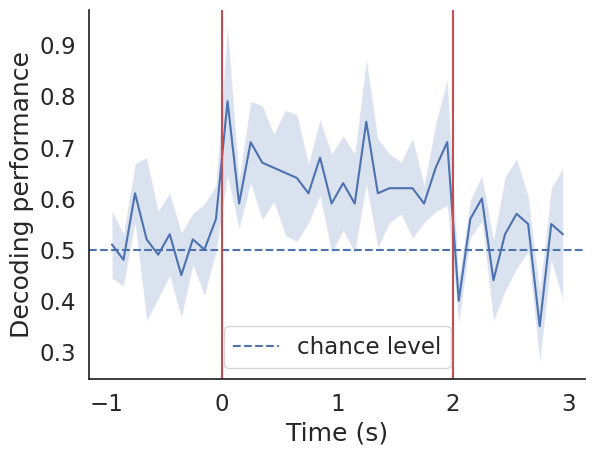

Plot with 20 cells, 0.1 stimulus sigma, and 1.2 noise sigma.


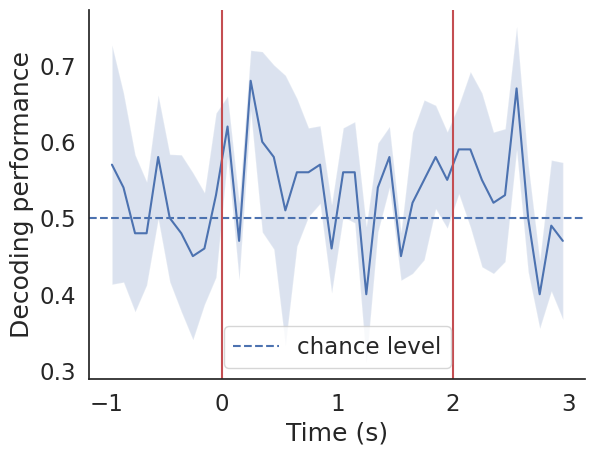

Plot with 20 cells, 0.6 stimulus sigma, and 0.2 noise sigma.


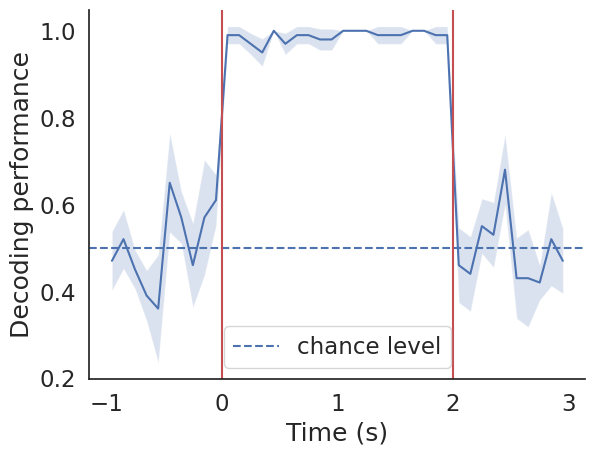

Plot with 20 cells, 0.6 stimulus sigma, and 0.6 noise sigma.


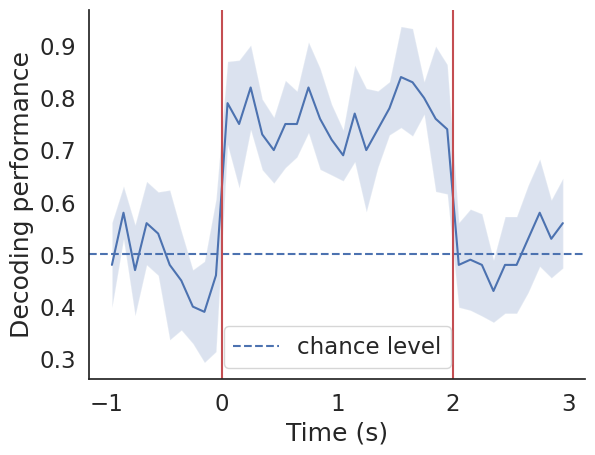

Plot with 20 cells, 0.6 stimulus sigma, and 1.2 noise sigma.


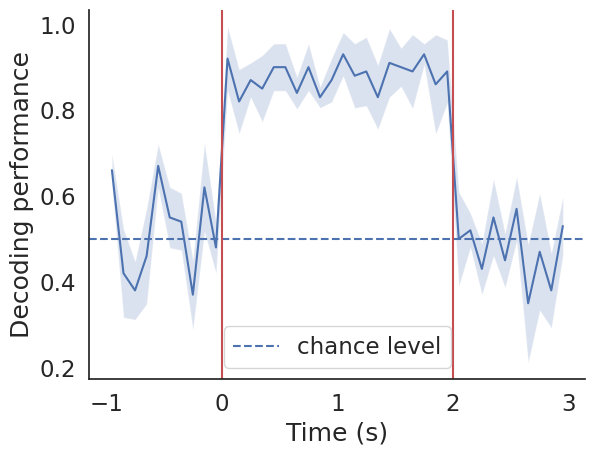

Plot with 20 cells, 1.0 stimulus sigma, and 0.2 noise sigma.


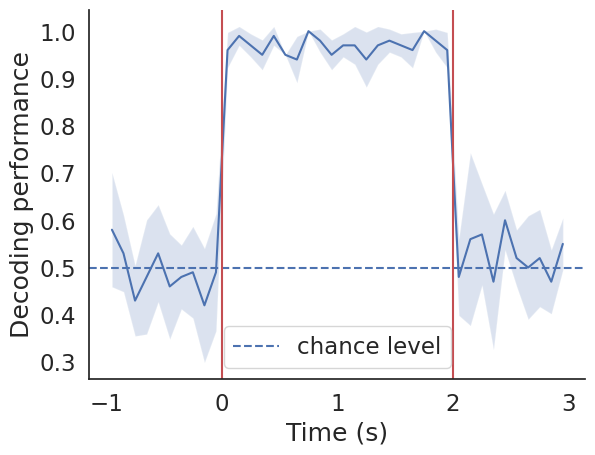

Plot with 20 cells, 1.0 stimulus sigma, and 0.6 noise sigma.


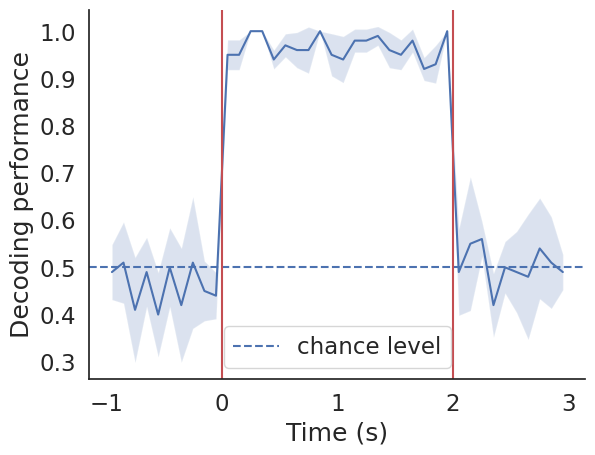

Plot with 20 cells, 1.0 stimulus sigma, and 1.2 noise sigma.


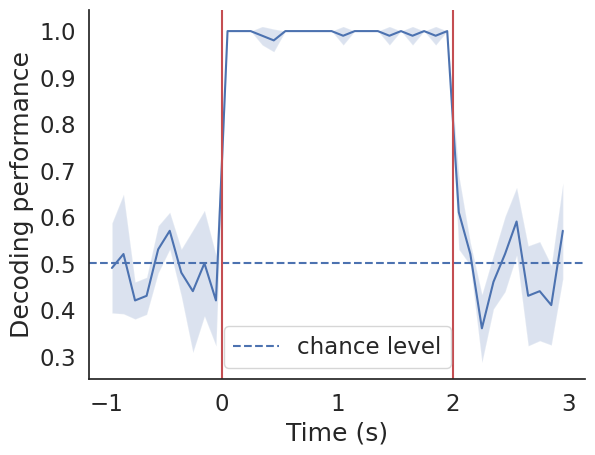

Plot with 60 cells, 0.1 stimulus sigma, and 0.2 noise sigma.


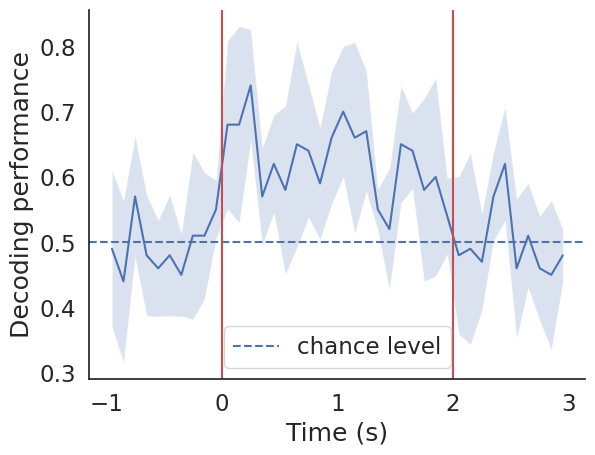

Plot with 60 cells, 0.1 stimulus sigma, and 0.6 noise sigma.


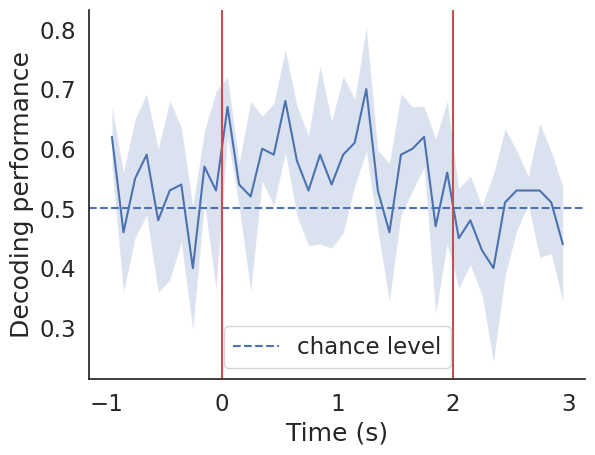

Plot with 60 cells, 0.1 stimulus sigma, and 1.2 noise sigma.


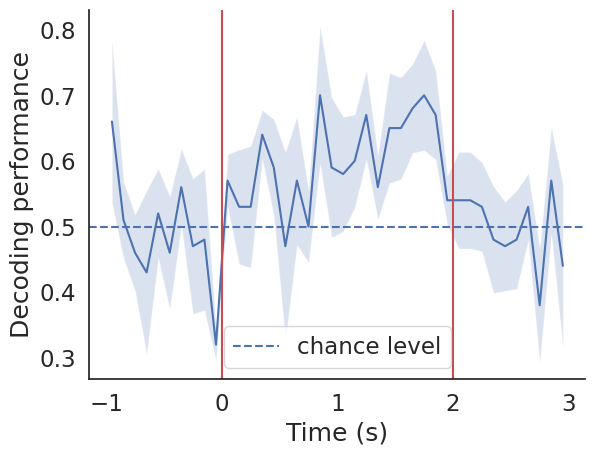

Plot with 60 cells, 0.6 stimulus sigma, and 0.2 noise sigma.


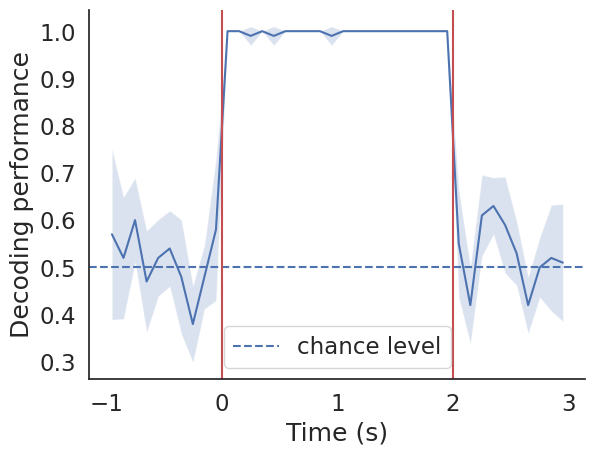

Plot with 60 cells, 0.6 stimulus sigma, and 0.6 noise sigma.


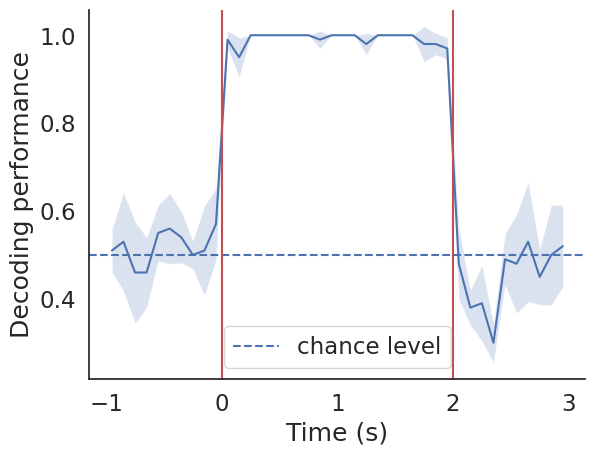

Plot with 60 cells, 0.6 stimulus sigma, and 1.2 noise sigma.


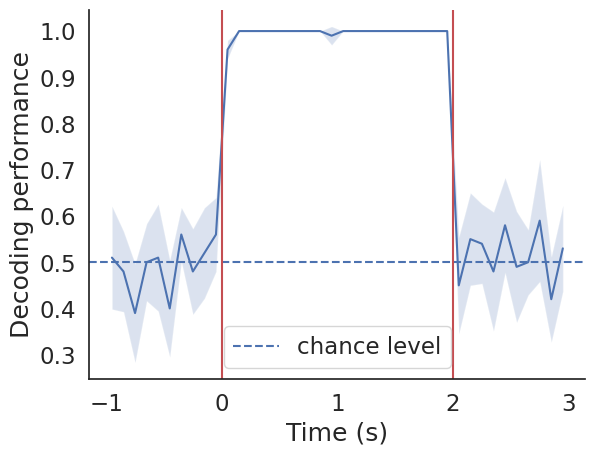

Plot with 60 cells, 1.0 stimulus sigma, and 0.2 noise sigma.


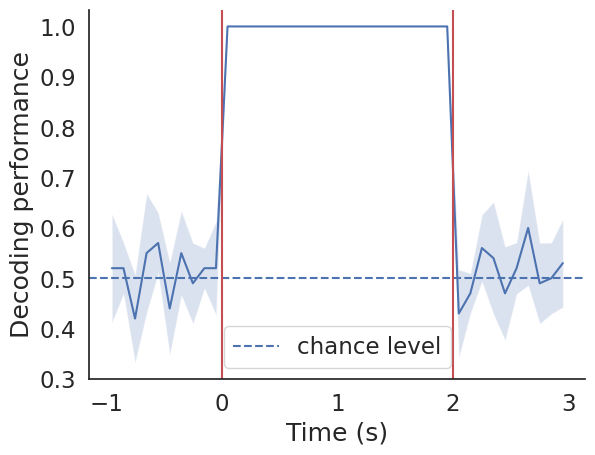

Plot with 60 cells, 1.0 stimulus sigma, and 0.6 noise sigma.


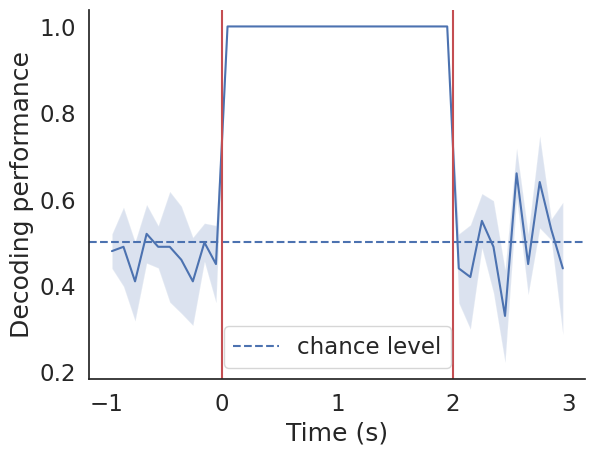

Plot with 60 cells, 1.0 stimulus sigma, and 1.2 noise sigma.


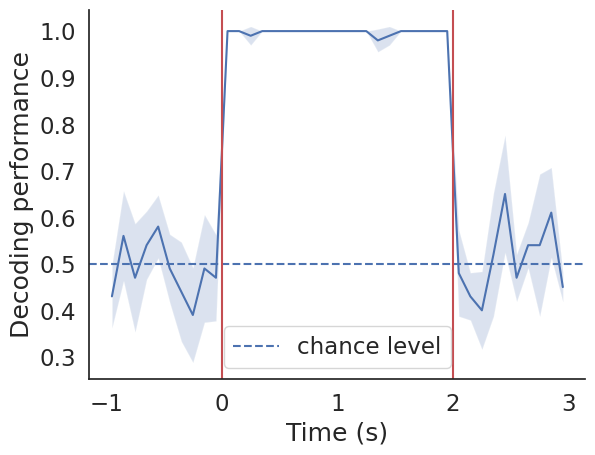

In [46]:
n_cells = [5, 20, 60]; # number of cells to simulate
sigma_stim = [0.1, 0.6, 1.0] # amplitude of stimulus related modulation
sigma_noise = [0.2, 0.6, 1.2] #amplitude of noise

for i in range(len(n_cells)):
    for j in range(len(sigma_stim)):
        for k in range(len(sigma_noise)):
            avg, std = ex3(n_cells[i], sigma_stim[j], sigma_noise[k])
            print(f'Plot with {n_cells[i]} cells, {sigma_stim[j]} stimulus sigma, and {sigma_noise[k]} noise sigma.')
            ex3_plot(avg, std)

## Results
Is a triple nested loop with huge function bodies an atrocity for computational time? **Absolutly**<br>
Are $3^3$ iterations/plots more than necessary? **Without a doubt**<br>
Is this bordering a warcrime? **quite possibly**<br>
Does it safe me the trouble of manipulating everything by hand, setting up subplots and/or saving multiple plots to make my observations? *perhaps*<br>

#### Observations
- The visibility of the decoding is dependend on the ration between stimulus and noise amplitude.
    - The amplitude of the stimulus has a bigger effect on it.
- A high number of cells result in a flat line during stimulation. 
    - It counteracts high noise.
    - It does not help if the stimulation has a small amplitude..

In [73]:
# save ouput
out_dict = {'spike_times':spike_times,
            'stim_onsets':stim_onsets,
            'stim_type':stim_type,
            'stim_duration':stim_dur
            }

with open('data/simulated_data1.pickle', 'wb') as handle:
    pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
